**novelty detection**:
The training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

**outlier detection**:
The training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

In [1]:
!source activate py2


CondaEnvironmentNotFoundError: Could not find environment: py2 .
You can list all discoverable environments with `conda info --envs`.



In [2]:
#!/anaconda3/envs/py2/bin/pip install cvxopt

In [4]:
import numpy as np
from cvxopt import solvers, lapack, matrix, spmatrix
solvers.options['show_progress'] = 0
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline

## Generate Data

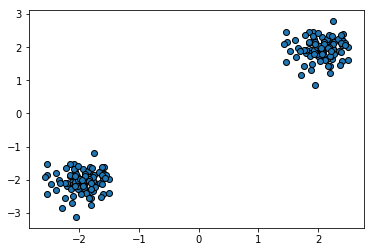

In [5]:
X = 0.3 * np.random.randn(100, 2)
X = np.r_[X + 2, X - 2]

def plot(X):
    plt.scatter(X[:,0], X[:,1], edgecolors  = 'black')
    pass

plot(X)


## Algorithms

### Basic solution : solving the dual by Quadratic Programming

\begin{aligned}
& \min_\alpha \frac{1}{2} \sum_{i,j} \alpha_i\alpha_j k(x_i,x_j) \\
& s.t. \ 0 \leq \alpha_i \leq \frac{1}{n \nu}, \ \sum_i \alpha_i = 1
\end{aligned}
In matrix form : 
\begin{aligned}
& \min_\alpha \frac{1}{2} \alpha^\top K \alpha \\ & s.t. \ \alpha \leq \frac{1}{n\nu}, \ 1^\top \alpha = 1
\end{aligned}

QP in standard form :

\begin{aligned}
& \min_x \frac{1}{2} x^\top P x + q^\top x \\
& s.t. \ Gx \leq h, \ Ax = b
\end{aligned}

In [7]:
def RBF_Kernel(X, sigma2, Y = None):
    " Compute the RBF kernel matrix of X"
    from sklearn.metrics.pairwise import euclidean_distances
    
    if type(Y)==type(None):
        Y = X
    
    K = euclidean_distances(X,Y, squared=True)
    K *= -1./sigma2
    K = np.exp(K)
    return K

In [286]:
def O_i(alpha,K,i):
    C_i = np.dot(K[i,:n],alpha)
    return(np.dot(K[:n,i],alpha)+C_i)

In [287]:
def C_i(alpha,K,i,j):
    return(np.sum([alpha[k]*K[i,k] for k in range(n) if k not in [i,j]]))

### Fit OCC with Sequential Minimal Optimization

In [336]:
%%capture
nu = 0.10
sigma2 = 0.10
n = X.shape[0]
K = RBF_Kernel(X, sigma2)
K = np.c_[ K, np.ones(n) ]
K = np.append(K, [np.ones(n+1)], axis = 0)

#### initialization ####
#init alpha
#problème: si on initialise les valeurs de alpha à zéro et une fraction nu à 1/(nu*n), alors SV_nb est vide...
#alpha=np.zeros(n)
alpha = np.random.uniform(0,nu/(n),size=n)  #randomize alpha
ind=np.random.choice(n,size=int(nu*n),replace=False)
alpha[ind]=1/int(nu*(n))  #fill fraction nu of alpha with edge value 1/(n*nu)
if (nu*(n)).is_integer()==False:
    alpha[ind[0]]=1-np.sum(np.delete(alpha,ind[0]))
print("check sum alpha",np.sum(alpha))  #check constraint sum(alpha)=1
#init rho
rho=np.max([O_i(alpha,K,i) for i in range(n) if alpha[i]>0])
print("rho init=",rho)

#### Optimization ####
for iter_ in range(1000):
    #define shorthand SV_nb: index of values of alpha that are not at bound
    SV_nb = [i for i in range(n) if (alpha[i]<1/(nu*n)) and (alpha[i]>0)]
    print(len(SV_nb))
    #loop through the entire dataset and find i that violates KKT condition
    i=0
    while( (i<n) and  (((O_i(alpha,K,i)-rho)*alpha[i]>0)==False) and \
          (((rho - O_i(alpha,K,i))*(1/(nu*n)-alpha[i]) > 0 )==False) ):
        i=i+1
    if i==n:
        break  #if no KKT violators are found, optimization is over
    print("i=",i)
    #pick alpha_j
    j=np.argmax([abs(O_i(alpha,K,i)-O_i(alpha,K,n)) for n in SV_nb])
    print("j=",j)
    #update alpha[j] according to eq (24)
    alpha[j] = alpha[j] + (O_i(alpha,K,i)-O_i(alpha,K,j))/(K[i,i]+K[j,j]-2*K[i,j])
    #delta = np.sum([alpha[k] for k in range(n) if k not in [i,j]])
    #alpha[i] = delta - alpha[j]
    alpha[i] = alpha[i] + (O_i(alpha,K,j)-O_i(alpha,K,i))/(K[i,i]+K[j,j]-2*K[j,i])
    print("alpha i",alpha[i])
    print("alpha j",alpha[j])
    #update rho
    rho=np.max([O_i(alpha,K,i) for i in range(n) if alpha[i]>0])
    print("updated rho",rho)

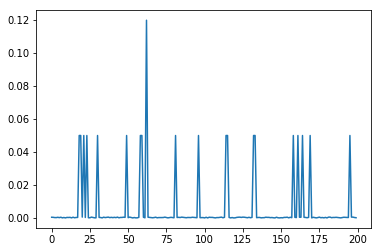

In [337]:
plt.plot(alpha)

In [338]:
print(np.sum(alpha))

1.1148641061641928


In [319]:
def predict(X, newData, alpha, rho, sigma2):
    n = X.shape[0]
    K = RBF_Kernel(X, sigma2, newData)
    return np.transpose(np.dot(np.reshape(alpha, (1,n)), K) - rho)

In [320]:
def get_grid(X, step = 0.05):
    x_axis = np.arange(min(X[:,0])-step,max(X[:,0])+2*step,step)
    y_axis = np.arange(min(X[:,1])-step,max(X[:,1])+2*step,step)

    my_grid = []
    for i in x_axis:
        for j in y_axis:
            my_grid.append([i,j])#,1])
    my_grid = np.array(my_grid)
    
    return x_axis, y_axis, my_grid

def Normalize_Pred(pred):    
    pred_100 = pred -np.min(pred)
    pred_100 = (pred_100 / np.max(pred_100)) * 100
    return pred_100

def get_delim(pred_100, x_axis, y_axis, eps = 0):
    ix_delim = np.where((pred_100  < eps) & (pred_100  > -eps))[0]
    x_delim = []
    y_delim = []
    for i in range(len(ix_delim)):
        a, b = np.divmod(ix_delim[i],len(y_axis))
        x_delim.append(x_axis[a])
        y_delim.append(y_axis[b])
    return x_delim, y_delim

def plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = 0.05):
    norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
    X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
    C = np.transpose(pred_100.reshape((len(x_axis), len(y_axis))))
    plt.pcolor(X_axis, Y_axis, C, norm= norm_colors, cmap = 'YlOrRd')
    plt.scatter(x_delim, y_delim, c = 'black', s = 10)
    plot(X)
    plt.xlim((min(X[:,0])-step,max(X[:,0])+step))
    plt.ylim((min(X[:,1])-step,max(X[:,1])+step))
    pass

def plot_pred_plan(X, alpha, rho, sigma2, step = 0.05, eps = 0):
    x_axis, y_axis, my_grid = get_grid(X, step)
    pred = predict(X, my_grid, alpha, rho, sigma2)
    x_delim, y_delim = get_delim(pred, x_axis, y_axis, eps)
    pred_100 = Normalize_Pred(pred)
    plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step)
    return pred

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


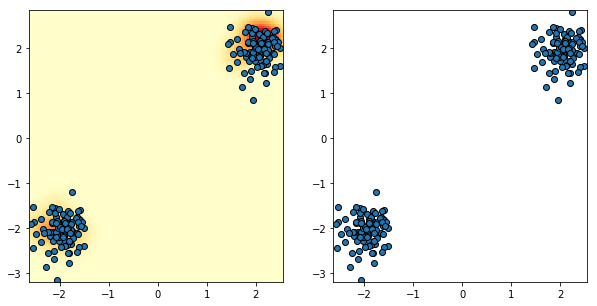

In [325]:
step = 0.05
nu = 0.1
sigma2 = 0.1

#alpha, rho = fit(X, nu, sigma2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
pred = plot_pred_plan(X, alpha, rho, sigma2, step = step)

plt.subplot(1,2,2)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

### Better solution : SMO variant